# Stock Price Forecasting and Sentiment Analysis

This notebook analyzes stock price trends, forecasts future prices using Prophet, and detects disruptive market events based on financial news sentiment analysis.

---




# Stock Price and Sentiment Analysis with Anomaly Detection

- 1. **Sentiment Analysis with Prophet Forecasting (Deviation Threshold Based)**

- 2. **Sentiment Analysis with Isolation Forest + Prophet Forecasting**

- 3. **Isolation Forest + ARIMA Forecasting**

- 4. **Sentiment Analysis with AWS Bedrock + Price Deviation**


# Sentiment Analysis with Prophet Forecasting (Deviation Threshold Based)

## Load Required Libraries

The following libraries are imported for data manipulation, sentiment analysis, forecasting, and plotting.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import mean_absolute_error


## Loading and Preprocessing Financial News Data
The financial news dataset is loaded, and sentiment scores for each article are extracted.


In [13]:
# --- Load Financial News Data ---
news_file = "tesla_financial_news_january.xlsx"
df_news = pd.read_excel(news_file, sheet_name="Sheet1")

# Convert Date column to datetime format
df_news["Date"] = pd.to_datetime(df_news["Date"]).dt.date

# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to compute sentiment scores
def get_sentiment(text):
    if pd.isna(text) or text.strip() == "":
        return 0  # Neutral if empty
    sentiment = analyzer.polarity_scores(text)
    return sentiment["compound"]

# Apply sentiment analysis to news titles
df_news["Sentiment"] = df_news["Title"].apply(get_sentiment)

# Aggregate daily average sentiment scores, ensure 'Title' remains in the DataFrame
df_news_sentiment = df_news[['Date', 'Sentiment', 'Title']].groupby("Date").agg({
    'Sentiment': 'mean',
    'Title': 'first'  # Keeps the first title for each date
}).reset_index()


## Loading Stock Data and Merging with Sentiment Scores
Stock price data is loaded and processed. The sentiment scores are merged with the stock data for analysis.


In [16]:
# --- Load Stock Data ---
df_stock = pd.read_excel('tesla_stock_prices.xlsx', sheet_name="Sheet1")

df_stock["Price_Change"] = df_stock["Close"] - df_stock["Open"]
df_stock["Percent_Change"] = (df_stock["Price_Change"] / df_stock["Open"]) * 100

df_news_sentiment['Date'] = pd.to_datetime(df_news_sentiment['Date'])

# Merge sentiment with stock price data
df_merged = pd.merge(df_stock, df_news_sentiment, on="Date", how="inner")


## Prophet Forecasting Setup
The stock data is prepared for Prophet, and the forecasting model is trained. A 15-day forecast is generated based on the historical data.


In [18]:
# --- Prophet Forecasting Setup ---
df_prophet = df_merged[['Date', 'Close']]
df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Close': 'y'})

# Set the frequency of the date column to daily
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
df_prophet = df_prophet.set_index('ds').asfreq('D').reset_index()  # Ensure daily frequency

# Initialize and train Prophet model
prophet = Prophet(daily_seasonality=True)
prophet.fit(df_prophet)

# Make a forecast for the next 15 days dynamically based on the data
future = prophet.make_future_dataframe(periods=15)
forecast = prophet.predict(future)

forecast.head()


10:37:54 - cmdstanpy - INFO - Chain [1] start processing
10:37:54 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2025-01-02,22.426738,378.593346,407.316288,22.426738,22.426738,370.605497,370.605497,370.605497,357.020718,357.020718,357.020718,13.584779,13.584779,13.584779,0.0,0.0,0.0,393.032234
1,2025-01-03,23.189656,387.032652,416.192628,23.189656,23.189656,378.460133,378.460133,378.460133,357.020718,357.020718,357.020718,21.439414,21.439414,21.439414,0.0,0.0,0.0,401.649789
2,2025-01-04,23.952575,322.003826,350.797049,23.952575,23.952575,312.392977,312.392977,312.392977,357.020718,357.020718,357.020718,-44.627742,-44.627742,-44.627742,0.0,0.0,0.0,336.345551
3,2025-01-05,24.715493,322.900786,350.505269,24.715493,24.715493,312.393082,312.393082,312.393082,357.020718,357.020718,357.020718,-44.627636,-44.627636,-44.627636,0.0,0.0,0.0,337.108576
4,2025-01-06,25.478412,380.934061,410.969292,25.478412,25.478412,371.393948,371.393948,371.393948,357.020718,357.020718,357.020718,14.373230,14.373230,14.373230,0.0,0.0,0.0,396.872359


## Compare Actual Price Change to Forecasted
The actual and forecasted stock prices are compared. Price deviation and sentiment are analyzed.


In [19]:
# --- Compare Actual Price Change to Forecasted ---
df_merged['Forecasted_Close'] = forecast['yhat'][-len(df_merged):].values
df_merged['Actual_Close'] = df_merged['Close']

# Calculate price deviation and compare with sentiment
df_merged['Price_Deviation'] = df_merged['Actual_Close'] - df_merged['Forecasted_Close']
df_merged['Percent_Deviation'] = (df_merged['Price_Deviation'] / df_merged['Forecasted_Close']) * 100


## --- Anomaly Detection Logic 1---
def detect_disruption(row):
    # Define a threshold for disruption (e.g., deviation > 2% and significant sentiment)
    price_deviation_threshold = 2  # percentage
    sentiment_threshold = 0.1  # sentiment score threshold to consider a strong reaction

    if abs(row['Percent_Deviation']) > price_deviation_threshold and abs(row['Sentiment']) > sentiment_threshold:
        return 'Disruptive'
    else:
        return 'Not Disruptive'

# Apply anomaly detection logic
df_merged['Disruptive'] = df_merged.apply(detect_disruption, axis=1)


In [20]:
# --- Anomaly Detection Logic ---
def detect_disruption(row):
    # Define a threshold for disruption (e.g., deviation > 2% and significant sentiment)
    price_deviation_threshold = 2  # percentage
    sentiment_threshold = 0.1  # sentiment score threshold to consider a strong reaction

    if abs(row['Percent_Deviation']) > price_deviation_threshold and abs(row['Sentiment']) > sentiment_threshold:
        return 'Disruptive'
    else:
        return 'Not Disruptive'

# Apply anomaly detection logic
df_merged['Disruptive'] = df_merged.apply(detect_disruption, axis=1)


## Plotting Stock Prices, Sentiment, and Disruptive Events
The stock prices, sentiment trends, and disruptive events are plotted for visualization.


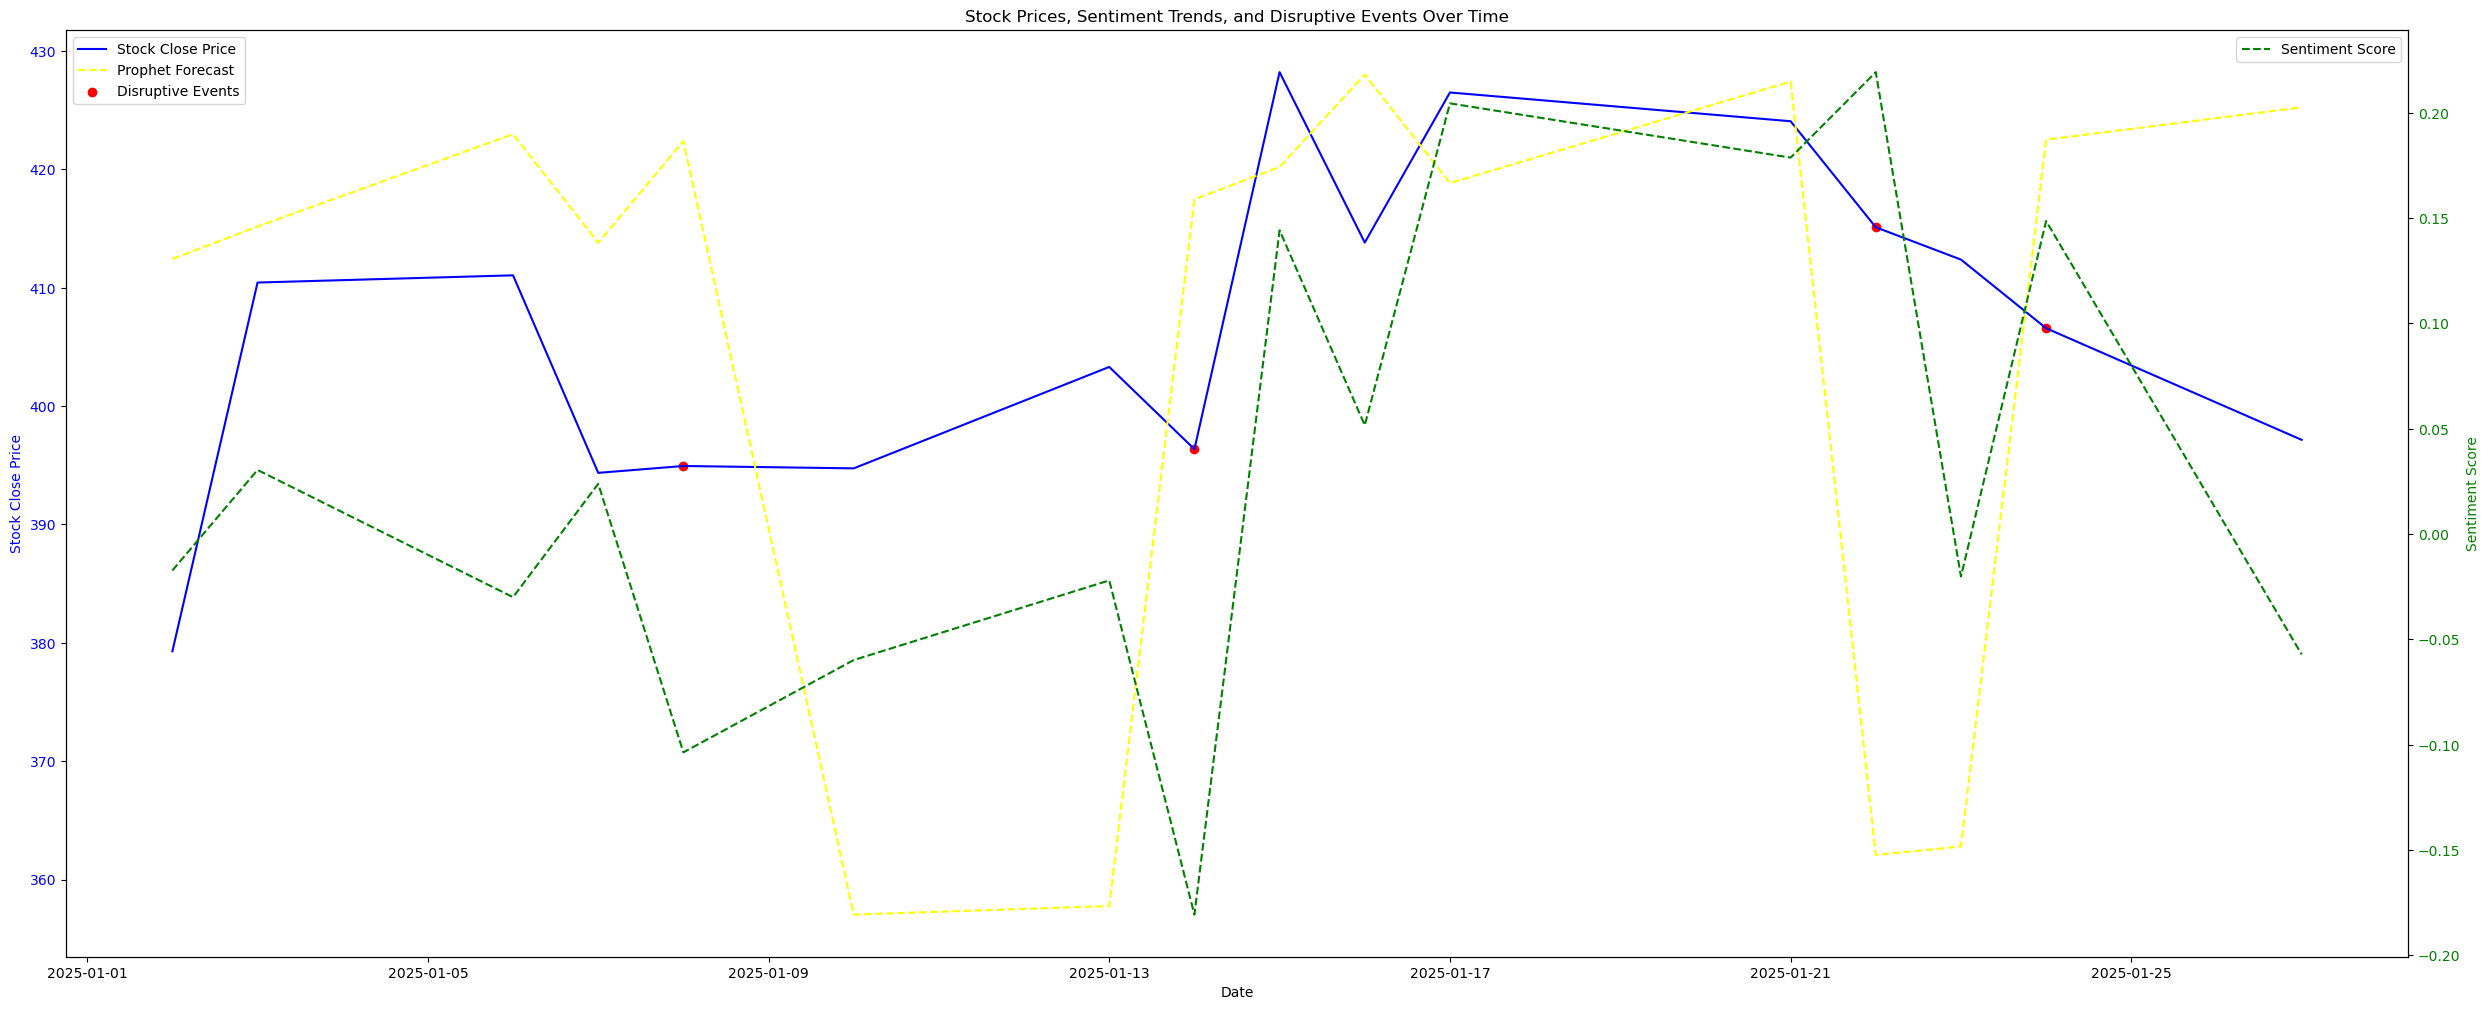

In [21]:
# --- Plotting Stock Prices, Sentiment, and Disruptive Events ---
fig, ax1 = plt.subplots(figsize=(25, 10))

# Plot Stock Price on the first y-axis (Blue)
ax1.set_xlabel("Date")
ax1.set_ylabel("Stock Close Price", color="blue")
ax1.plot(df_merged["Date"], df_merged["Close"], color="blue",  label="Stock Close Price")

# Plot Prophet Forecast on the first y-axis (Yellow)
ax1.plot(df_merged["Date"], df_merged["Forecasted_Close"], color="yellow", linestyle="--", label="Prophet Forecast")

ax1.tick_params(axis="y", labelcolor="blue")

# Create a second y-axis for the sentiment scores (Green)
ax2 = ax1.twinx()
ax2.set_ylabel("Sentiment Score", color="green")
ax2.plot(df_merged["Date"], df_merged["Sentiment"], color="green", linestyle="dashed", label="Sentiment Score")
ax2.tick_params(axis="y", labelcolor="green")

# Highlight disruptive events with red dots
disruptive = df_merged[df_merged['Disruptive'] == 'Disruptive']
ax1.scatter(disruptive['Date'], disruptive['Actual_Close'], color='red', label='Disruptive Events')

# Add title and labels
fig.tight_layout()
plt.title("Stock Prices, Sentiment Trends, and Disruptive Events Over Time")

# Show legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.xticks(rotation=45)
plt.show()


# Sentiment Analysis with Isolation Forest + Prophet Forecasting
In this section, an anomaly detection model is applied to identify disruptive events using the Isolation Forest algorithm. This model helps detect outliers in the data based on sentiment, price deviation, and percentage deviation from forecasted values.

##  Importing Required Libraries
The necessary libraries for anomaly detection and plotting are imported.


In [23]:
from sklearn.ensemble import IsolationForest
import pandas as pd


In [24]:
# --- Anomaly Detection using Isolation Forest ---
features = ['Sentiment', 'Price_Deviation', 'Percent_Deviation']  # Features used for anomaly detection
X = df_merged[features]

# Train Isolation Forest model
model = IsolationForest(contamination=0.1)  # Adjust contamination based on expected anomaly ratio
df_merged['Anomaly'] = model.fit_predict(X)

# Anomalies are marked as -1
df_merged['Anomaly_Label'] = df_merged['Anomaly'].apply(lambda x: 'Disruptive' if x == -1 else 'Not Disruptive')

# Check results
print(df_merged[['Date', 'Sentiment', 'Price_Deviation', 'Percent_Deviation', 'Anomaly_Label']])


         Date  Sentiment  Price_Deviation  Percent_Deviation   Anomaly_Label
0  2025-01-02  -0.017292       -33.157345          -8.039365  Not Disruptive
1  2025-01-03   0.030441        -4.730005          -1.139293  Not Disruptive
2  2025-01-06  -0.029971       -11.925080          -2.819334  Not Disruptive
3  2025-01-07   0.023850       -19.447799          -4.699718  Not Disruptive
4  2025-01-08  -0.103640       -27.442049          -6.496973  Not Disruptive
5  2025-01-10  -0.059812        37.705465          10.560733      Disruptive
6  2025-01-13  -0.022005        45.555735          12.733806  Not Disruptive
7  2025-01-14  -0.180667       -21.114773          -5.057736  Not Disruptive
8  2025-01-15   0.144178         8.012580           1.906815  Not Disruptive
9  2025-01-16   0.051671       -14.192475          -3.315902  Not Disruptive
10 2025-01-17   0.204484         7.654801           1.827597  Not Disruptive
11 2025-01-21   0.178724        -3.349458          -0.783647  Not Disruptive

## Visualizing Anomalies
Disruptive events detected by the Isolation Forest model are highlighted in red. Stock prices, sentiment trends, and disruptive events are plotted together for visualization.


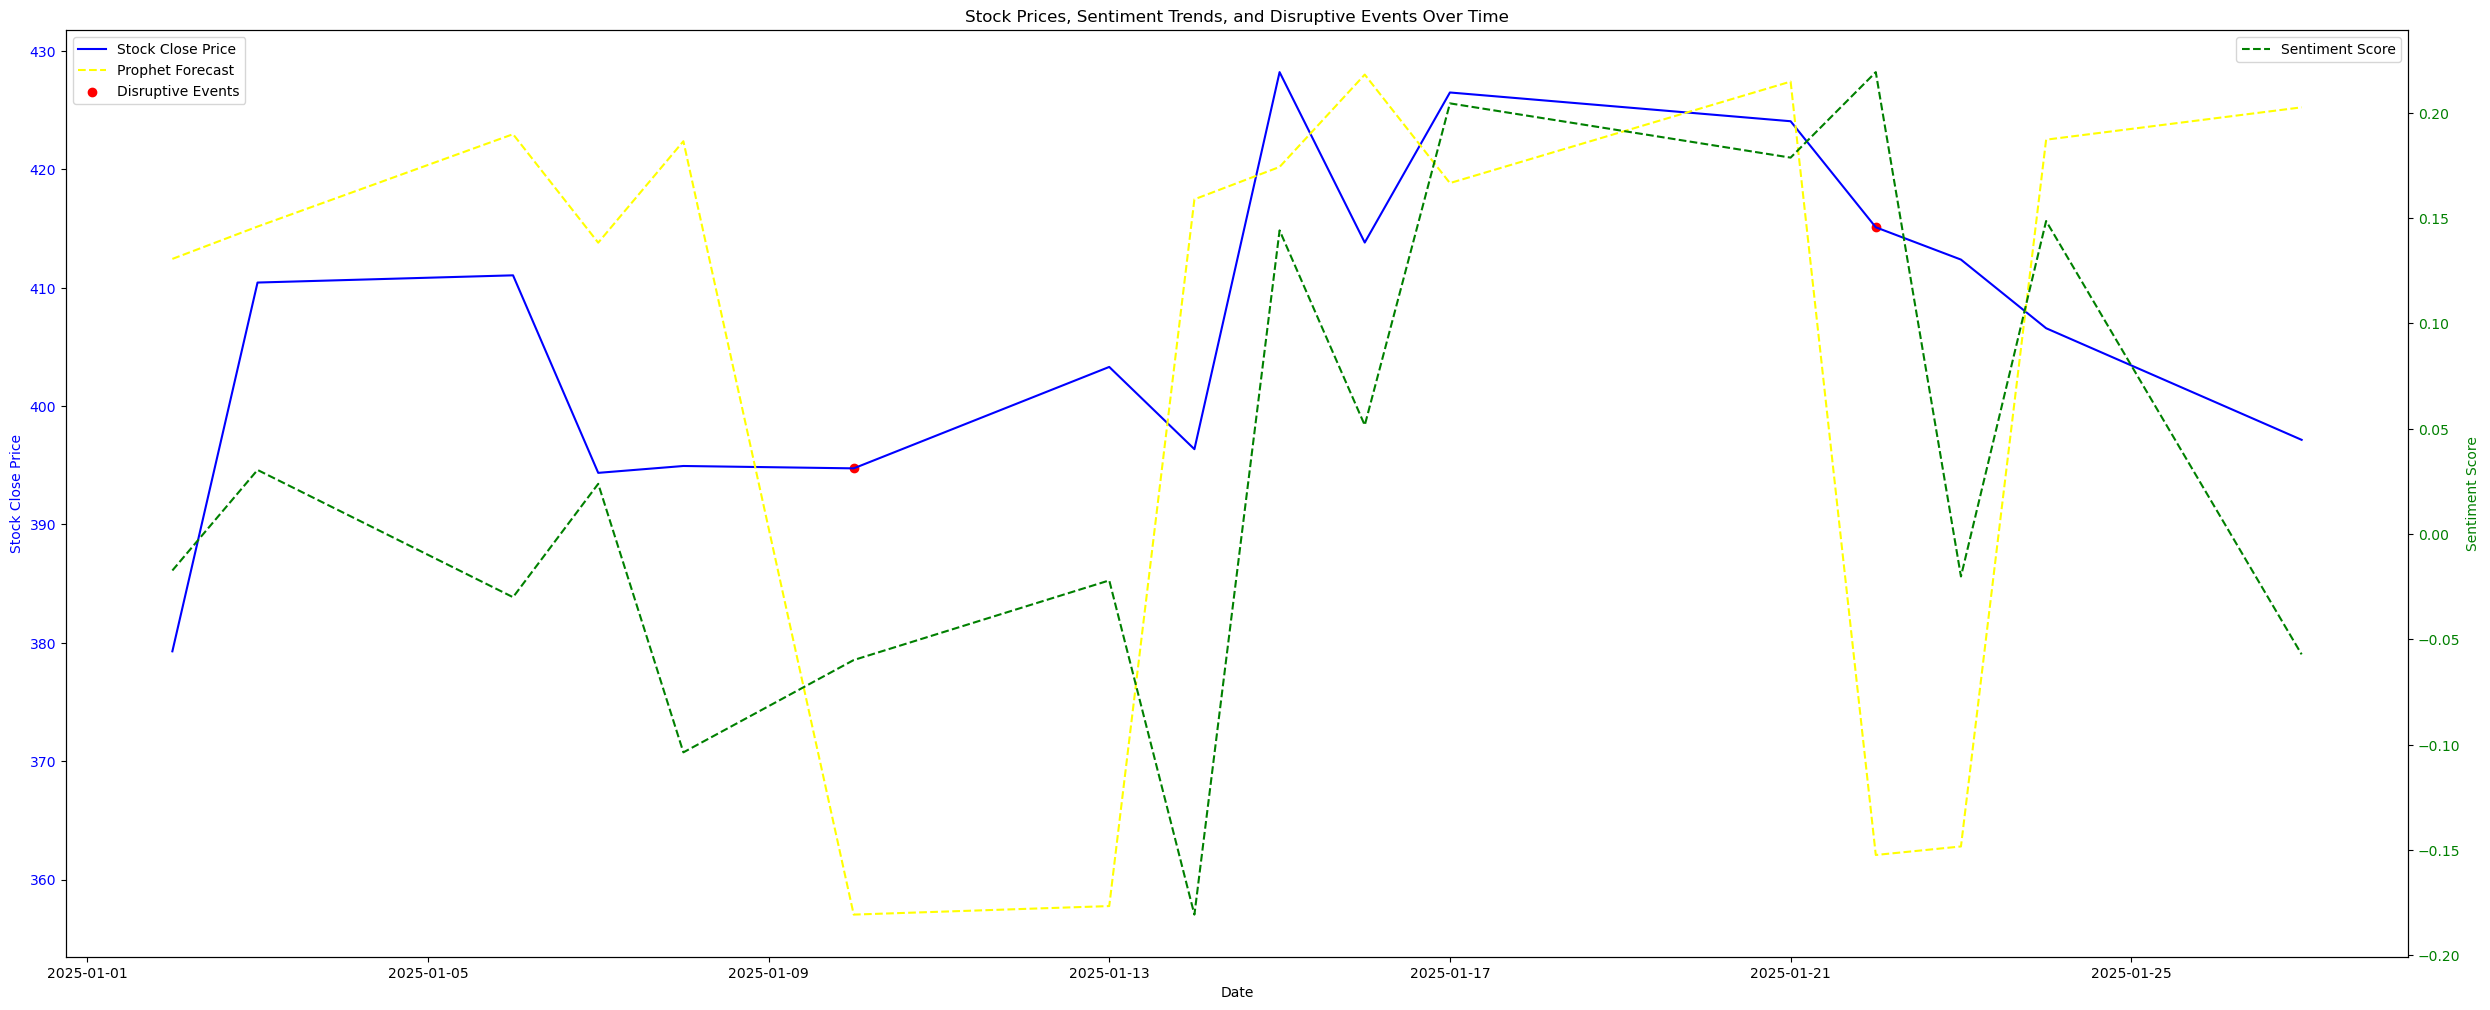

In [25]:
# --- Visualize Anomalies ---
disruptive = df_merged[df_merged['Anomaly_Label'] == 'Disruptive']

# Create a figure and axis for plotting
fig, ax1 = plt.subplots(figsize=(25, 10))

# Plot Stock Price and Prophet Forecast
ax1.set_xlabel("Date")
ax1.set_ylabel("Stock Close Price", color="blue")
ax1.plot(df_merged["Date"], df_merged["Close"], color="blue", label="Stock Close Price")
ax1.plot(df_merged["Date"], df_merged["Forecasted_Close"], color="yellow", linestyle="--", label="Prophet Forecast")
ax1.tick_params(axis="y", labelcolor="blue")

# Create a second y-axis for sentiment score
ax2 = ax1.twinx()
ax2.set_ylabel("Sentiment Score", color="green")
ax2.plot(df_merged["Date"], df_merged["Sentiment"], color="green", linestyle="dashed", label="Sentiment Score")
ax2.tick_params(axis="y", labelcolor="green")

# Highlight disruptive events with red dots
ax1.scatter(disruptive['Date'], disruptive['Actual_Close'], color='red', label='Disruptive Events')

# Finalize plot
fig.tight_layout()
plt.title("Stock Prices, Sentiment Trends, and Disruptive Events Over Time")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.xticks(rotation=45)
plt.show()


# ARIMA Forecasting and Isolation Forest for Anomaly Detection
This section applies the ARIMA model for forecasting stock prices and uses the Isolation Forest algorithm to detect anomalies based on sentiment and price deviation.

## Preparing the Data for ARIMA
The stock data and sentiment scores are merged, and the data is prepared for ARIMA forecasting.


In [26]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

# --- ARIMA Forecasting Setup ---
# Prepare stock data for ARIMA
df_merged_arima = df_merged[['Date', 'Close']]
df_merged_arima = df_merged_arima.set_index('Date')

# Fit ARIMA model
model_arima = ARIMA(df_merged_arima['Close'], order=(5, 1, 0))  # Adjust (p, d, q) as needed
model_arima_fit = model_arima.fit()

# Forecast stock prices
forecast_steps = len(df_merged_arima)
forecast_arima = model_arima_fit.forecast(steps=forecast_steps)

# Align forecast with the stock data
df_merged_arima['Forecasted_Close'] = forecast_arima


/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/p

## Compare Actual and Forecasted Prices
The actual and forecasted stock prices are compared, and the deviation is calculated.


In [28]:
# --- Compare Actual Price Change to Forecasted ---
df_merged['Forecasted_Close'] = df_merged_arima['Forecasted_Close'].values
df_merged['Actual_Close'] = df_merged['Close']

# Calculate price deviation and compare with sentiment
df_merged['Price_Deviation'] = df_merged['Actual_Close'] - df_merged['Forecasted_Close']
df_merged['Percent_Deviation'] = (df_merged['Price_Deviation'] / df_merged['Forecasted_Close']) * 100


## Anomaly Detection with Isolation Forest
The Isolation Forest model is trained using the features 'Sentiment' and 'Price_Deviation' to detect anomalies. The anomalies are labeled as 'Disruptive' or 'Not Disruptive.'


In [29]:
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer

# --- Anomaly Detection with Isolation Forest ---
# Prepare the feature set for anomaly detection
X = df_merged[['Sentiment', 'Price_Deviation']]  # Add other features as needed

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Train Isolation Forest model for anomaly detection
model_if = IsolationForest(contamination=0.1)  # Adjust contamination based on expected anomaly ratio
df_merged['Anomaly'] = model_if.fit_predict(X_imputed)

# Anomalies are marked as -1
df_merged['Anomaly_Label'] = df_merged['Anomaly'].apply(lambda x: 'Disruptive' if x == -1 else 'Not Disruptive')


/opt/conda/lib/python3.11/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['Price_Deviation']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


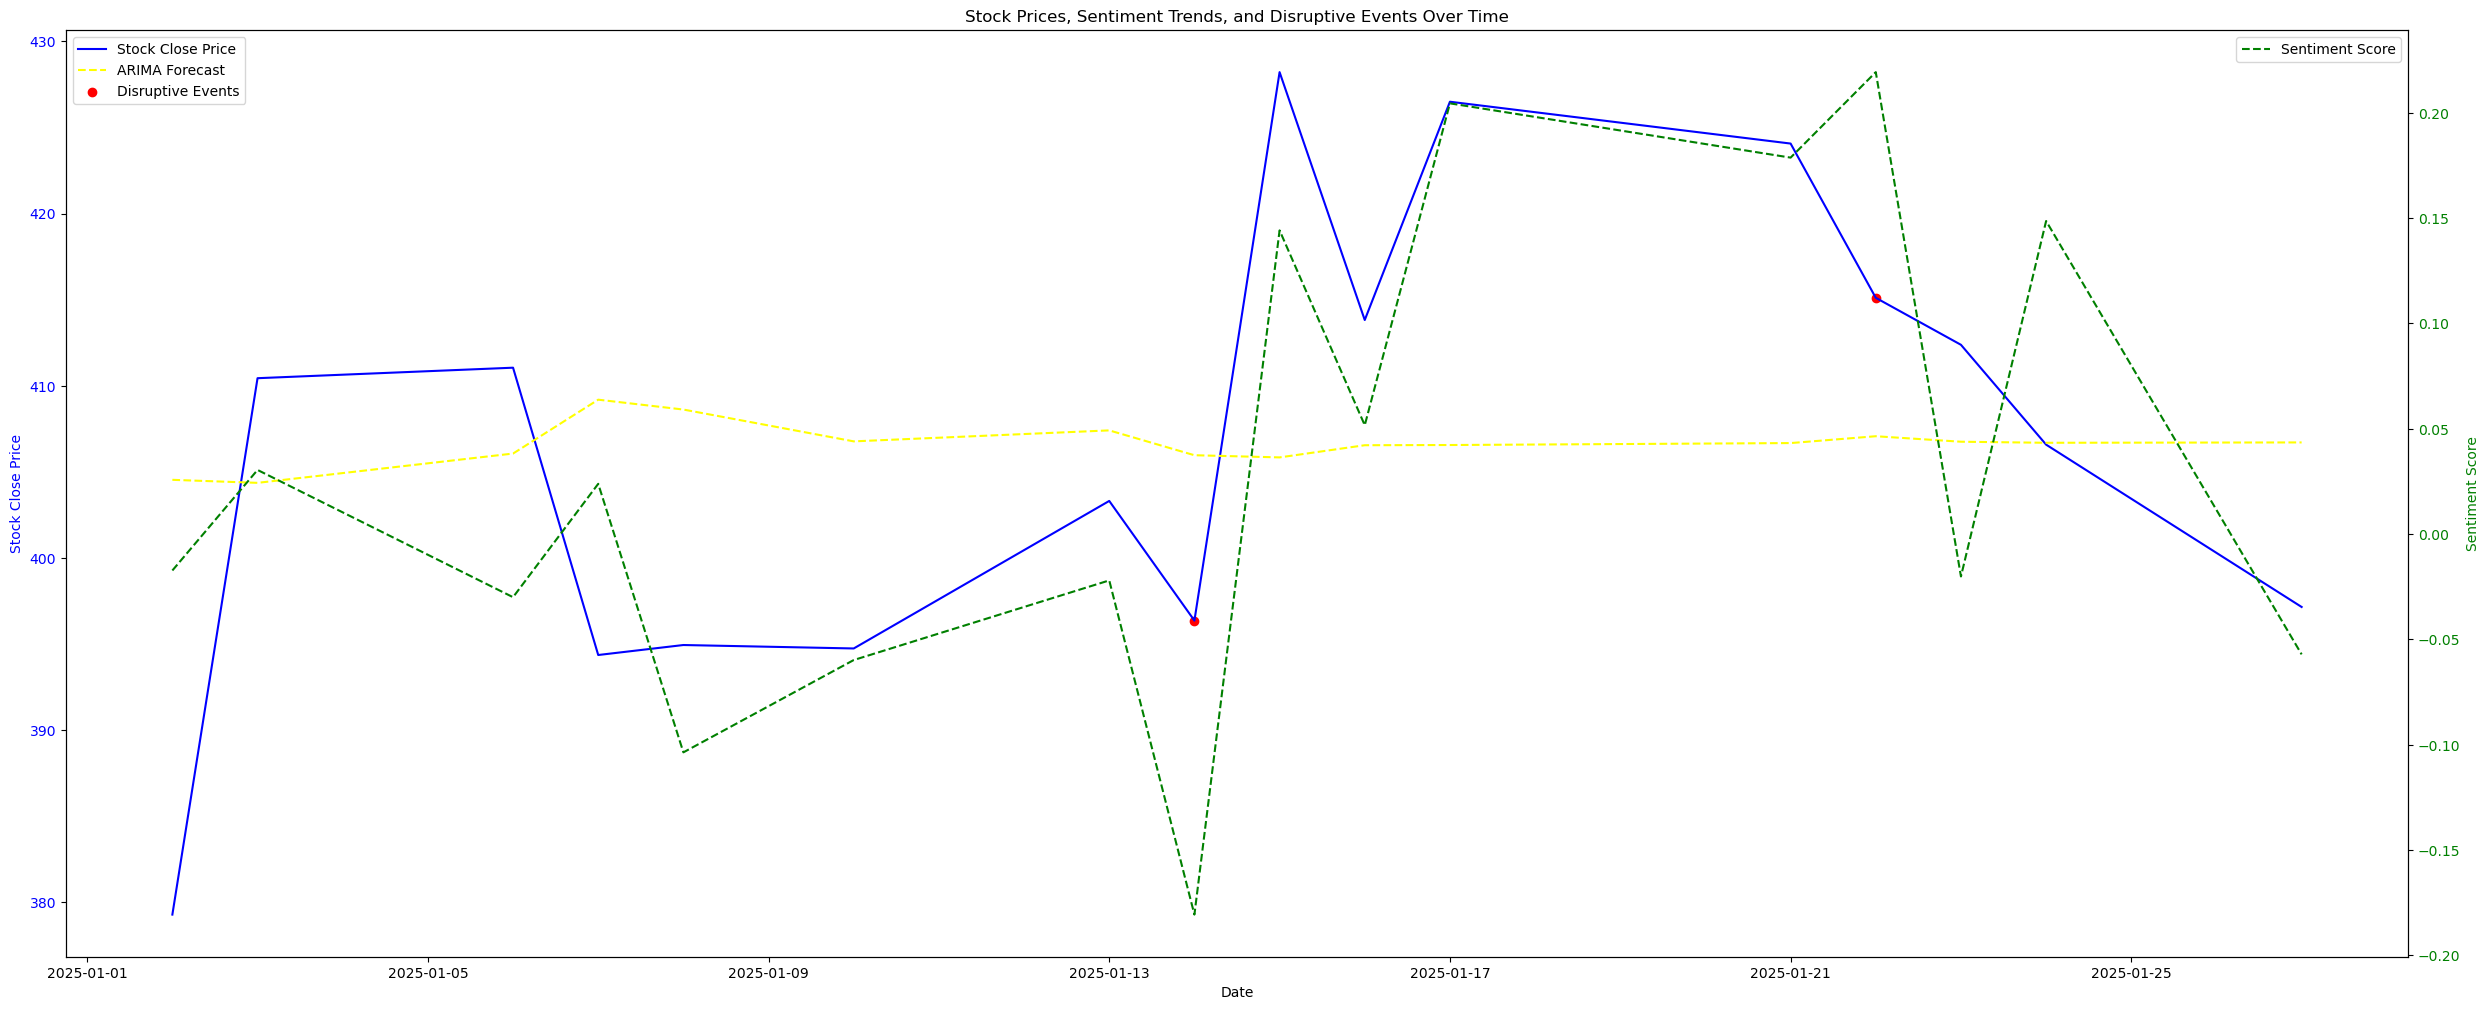

In [30]:
# --- Plotting Stock Prices, Sentiment, and Disruptive Events ---
# Create a figure and axis for plotting
fig, ax1 = plt.subplots(figsize=(25, 10))

# Plot Stock Price on the first y-axis (Blue)
ax1.set_xlabel("Date")
ax1.set_ylabel("Stock Close Price", color="blue")
ax1.plot(df_merged["Date"], df_merged["Close"], color="blue", label="Stock Close Price")

# Plot ARIMA Forecast on the first y-axis (Yellow)
ax1.plot(df_merged["Date"], forecast_arima, color="yellow", linestyle="--", label="ARIMA Forecast")

ax1.tick_params(axis="y", labelcolor="blue")

# Create a second y-axis for the sentiment scores (Green)
ax2 = ax1.twinx()
ax2.set_ylabel("Sentiment Score", color="green")
ax2.plot(df_merged["Date"], df_merged["Sentiment"], color="green", linestyle="dashed", label="Sentiment Score")
ax2.tick_params(axis="y", labelcolor="green")

# Highlight disruptive events with red dots
disruptive = df_merged[df_merged['Anomaly_Label'] == 'Disruptive']
ax1.scatter(disruptive['Date'], disruptive['Actual_Close'], color='red', label='Disruptive Events')

# Add title and labels
fig.tight_layout()
plt.title("Stock Prices, Sentiment Trends, and Disruptive Events Over Time")

# Show legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.xticks(rotation=45)
plt.show()


# AWS Bedrock Sentiment Analysis and Anomaly Detection
This section applies AWS Bedrock for sentiment analysis to detect disruptive news based on the comparison of actual price changes and forecasted stock prices. Disruptive news is then plotted along with other detected anomalies.

## Function for Sentiment Analysis using AWS Bedrock
The function sends a prompt to AWS Bedrock, invoking the `claude-v2` model for sentiment analysis.


In [31]:
import boto3
import json

# Function to invoke AWS Bedrock for sentiment analysis
def detect_disruptive_news(news_title, actual_price_change, forecasted_price):
    # Define the prompt for sentiment analysis
    prompt = f"""
    \n\nHuman: The stock was expected to close at {forecasted_price}, but the actual price change was {actual_price_change}%.
    Given the news headline: "{news_title}", did this news cause an unexpected market reaction?
    
    \n\nAssistant: Respond only with "Disruptive" or "Not Disruptive". No extra explanation.
    """
    
    # Initialize the Bedrock client
    bedrock = boto3.client("bedrock-runtime")
    
    try:
        # Call the model
        response = bedrock.invoke_model(
            modelId="anthropic.claude-v2",  # Choose the model ID (Claude-v2 in this case)
            contentType="application/json",
            accept="application/json",
            body=json.dumps({
                "prompt": prompt,
                "max_tokens_to_sample": 10,
                "temperature": 0.5,
                "top_k": 250,
                "top_p": 1,
                "stop_sequences": ["\n\nHuman:"],
                "anthropic_version": "bedrock-2023-05-31"
            })
        )
        
        # Parse the response to get the result
        result = json.loads(response["body"].read())
        return result['completion'].strip()  # Should return 'Disruptive' or 'Not Disruptive'
    
    except Exception as e:
        print(f"Error invoking Bedrock: {e}")
        return "Unknown"  # Return Unknown in case of failure


## Apply Sentiment Analysis and Compare with Stock Data
This function processes the news and stock data, applying the Bedrock sentiment model and returning the results as a DataFrame.


In [42]:
# Function to apply sentiment analysis to news and compare stock data
def analyze_disruptive_news(df_news, df_stock):
    results = []
    # Convert Date column to datetime format
    df_news["Date"] = pd.to_datetime(df_news["Date"]).dt.date

    # Convert Date column to datetime format
    df_stock["Date"] = pd.to_datetime(df_stock["Date"]).dt.date
    
    # Iterate over the news dataframe
    for _, row in df_news.iterrows():
        date = row['Date']
        news_title = row['Title']
        
        # Ensure matching stock data for the same date
        stock_data = df_stock[df_stock['Date'] == date]
        
        if not stock_data.empty:
            actual_price_change = stock_data['Percent_Change'].values[0]
            forecasted_price = stock_data['Forecasted_Close'].values[0]
            
            # Detect if the news caused a disruption based on price movement
            disruption_status = detect_disruptive_news(news_title, actual_price_change, forecasted_price)
            results.append((date, news_title, disruption_status))
        else:
            results.append((date, news_title, "No stock data"))
    
    # Create a DataFrame for the results
    df_results = pd.DataFrame(results, columns=['Date', 'Title', 'Disruptive'])
    
    return df_results


## Plot Anomalies Detected by AWS Bedrock
This function plots the stock price change and highlights the anomalies detected using AWS Bedrock sentiment analysis.


In [55]:
import matplotlib.pyplot as plt

# Function to plot anomalies
def plot_anomalies(df_news, df_stock):
    # Merge news and stock data for easy comparison
    merged_df = pd.merge(df_news, df_stock, on='Date', how='inner')
    
    # Filter out non-disruptive news
    anomalies = merged_df[merged_df['Anomaly_Label'] == 'Disruptive']
    
    # Plotting the actual price change and anomalies
    plt.figure(figsize=(12, 6))
    plt.plot(df_stock['Date'], df_stock['Percent_Change'], label='Stock Price Change (%)', color='blue', alpha=0.5)
    plt.scatter(anomalies['Date'], anomalies['Percent_Change'], color='red', label='Disruptive News', zorder=5)
    
    # Labeling the plot
    plt.title('Stock Price Changes and Disruptive News Anomalies')
    plt.xlabel('Date')
    plt.ylabel('Price Change (%)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


## Combine with Previous Logic and Plot Together
This part integrates the results from **ARIMA** and **Isolation Forest** anomaly detection, alongside the **AWS Bedrock** anomaly detection, and plots them together.


In [43]:
# --- ARIMA Forecasting ---
df_merged_arima = df_merged[['Date', 'Close']].set_index('Date')
model_arima = ARIMA(df_merged_arima['Close'], order=(5, 1, 0))  # Adjust order as needed
model_arima_fit = model_arima.fit()
forecast_arima = model_arima_fit.forecast(steps=len(df_merged_arima))

# Add ARIMA Forecast to df_merged
df_merged['Forecasted_Close'] = forecast_arima

# Calculate Price Deviation
df_merged['Price_Deviation'] = df_merged['Close'] - df_merged['Forecasted_Close']
df_merged['Percent_Deviation'] = (df_merged['Price_Deviation'] / df_merged['Forecasted_Close']) * 100

# --- Ensure Forecasted_Close is part of df_stock ---
df_stock['Forecasted_Close'] = forecast_arima



/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/p

In [47]:
# --- Now proceed with the disruption detection ---
df_disruptive = analyze_disruptive_news(df_news, df_stock)


In [48]:
# Convert Date column to datetime format
df_disruptive["Date"] = pd.to_datetime(df_disruptive["Date"]).dt.date
df_merged["Date"] = pd.to_datetime(df_merged["Date"]).dt.date
df_merged = pd.merge(df_merged, df_disruptive[['Date', 'Disruptive']], on='Date', how='left')


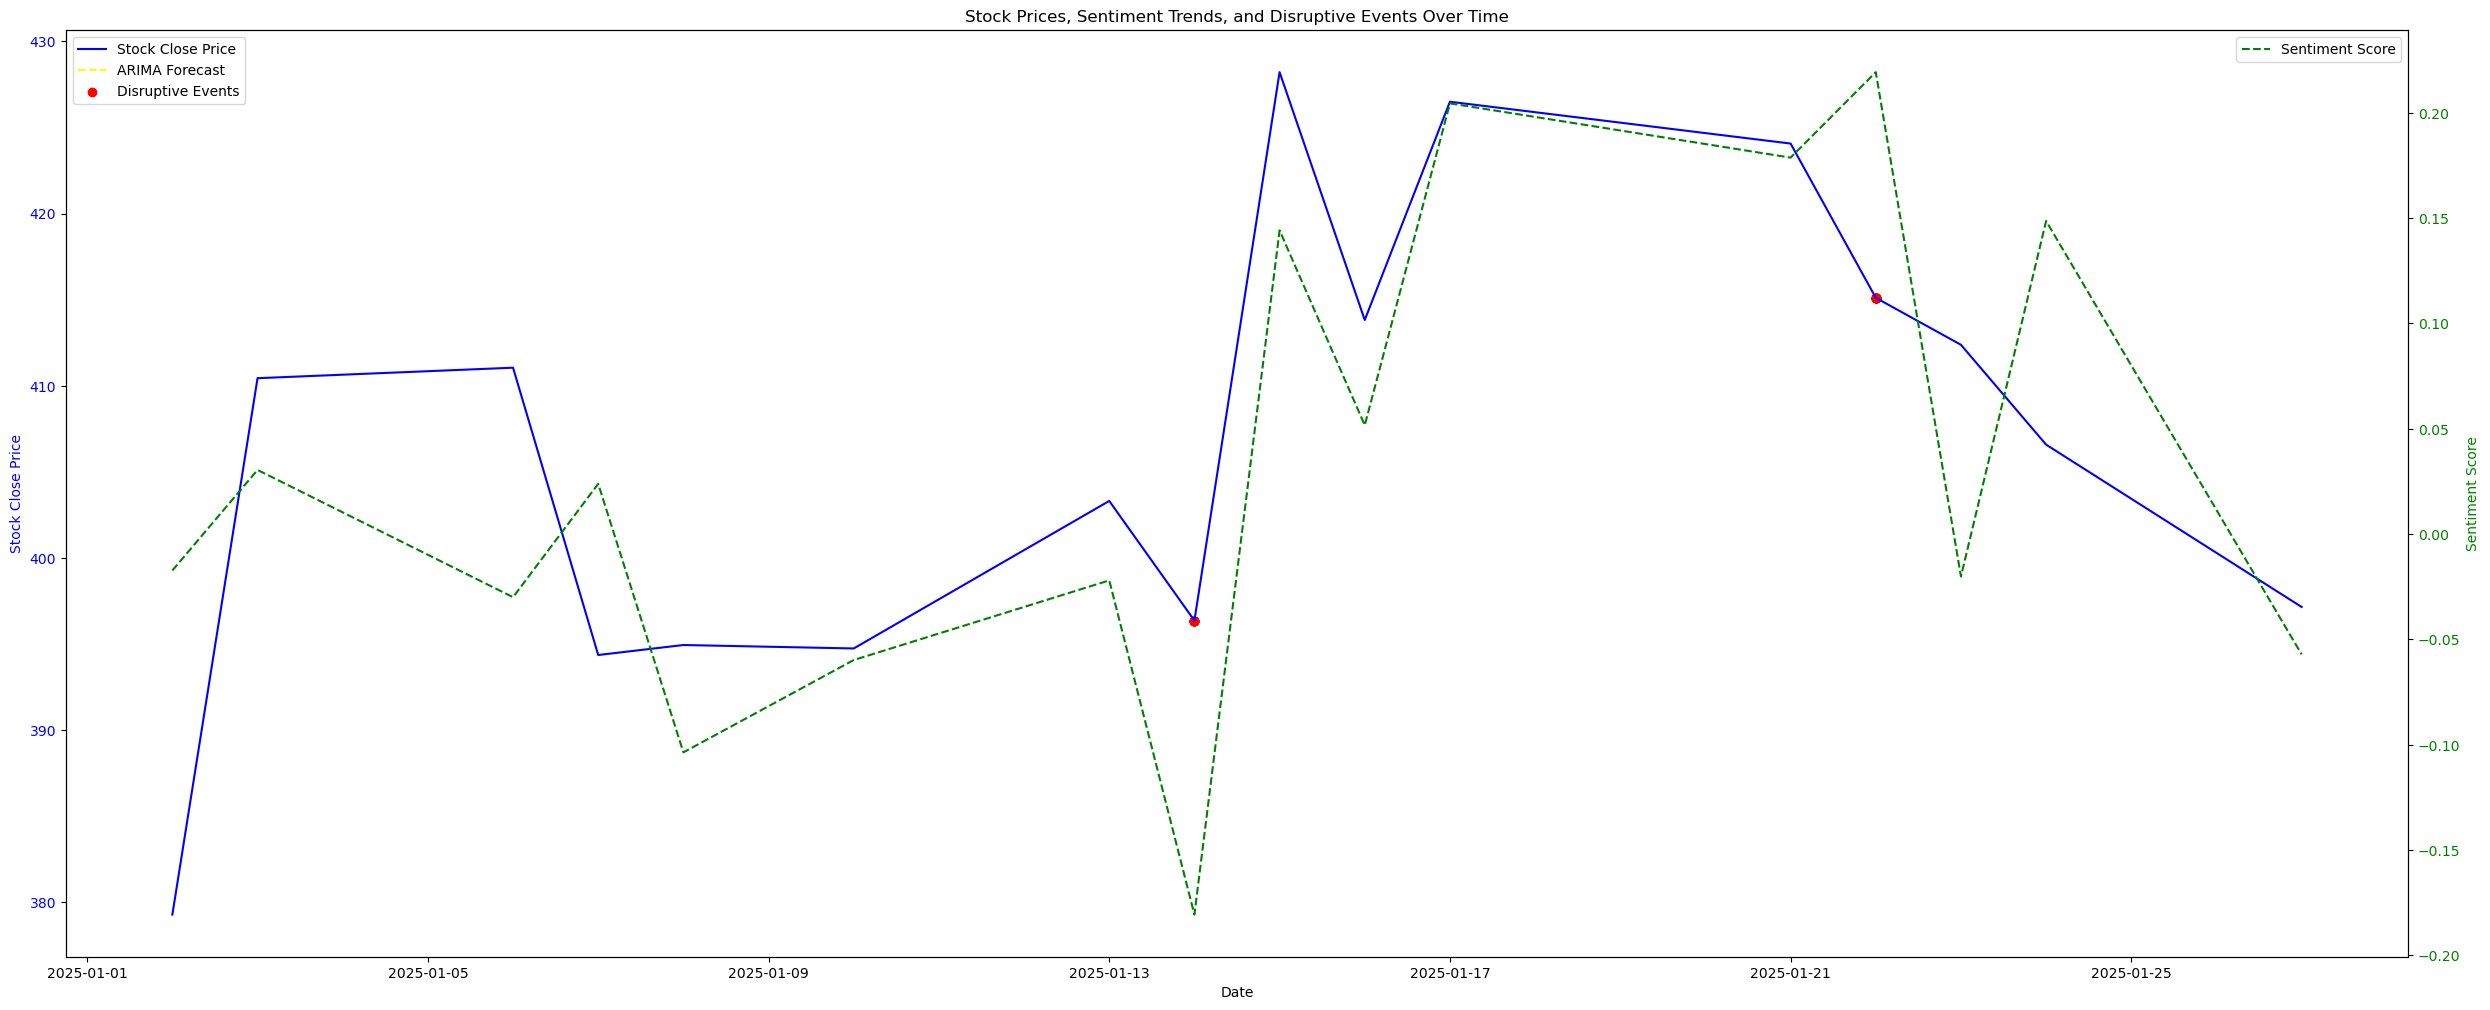

In [52]:
# --- Continue with plotting ---
fig, ax1 = plt.subplots(figsize=(25, 10))

# Plot Stock Price and ARIMA Forecast
ax1.set_xlabel("Date")
ax1.set_ylabel("Stock Close Price", color="blue")
ax1.plot(df_merged["Date"], df_merged["Close"], color="blue", label="Stock Close Price")
ax1.plot(df_merged["Date"], df_merged["Forecasted_Close"], color="yellow", linestyle="--", label="ARIMA Forecast")
ax1.tick_params(axis="y", labelcolor="blue")

# Create second y-axis for Sentiment Score
ax2 = ax1.twinx()
ax2.set_ylabel("Sentiment Score", color="green")
ax2.plot(df_merged["Date"], df_merged["Sentiment"], color="green", linestyle="dashed", label="Sentiment Score")
ax2.tick_params(axis="y", labelcolor="green")

# Highlight disruptive events with red dots
disruptive = df_merged[df_merged['Anomaly_Label'] == 'Disruptive']
ax1.scatter(disruptive['Date'], disruptive['Close'], color='red', label='Disruptive Events')

# Finalize plot
fig.tight_layout()
plt.title("Stock Prices, Sentiment Trends, and Disruptive Events Over Time")

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.xticks(rotation=45)
plt.show()


In [53]:
#df_merged

In [66]:
import matplotlib.pyplot as plt

# Function to plot anomalies
def plot_anomalies(df_news, df_stock,merged_df):
    # Merge news and stock data for easy comparison
    merged_df = pd.merge(df_news, df_stock, on='Date', how='inner')

    
    # Filter out non-disruptive news
    anomalies = merged_df[merged_df['Anomaly_Label'] == 'Disruptive']
    
    # Plotting the actual price change and anomalies
    plt.figure(figsize=(12, 6))
    plt.plot(df_stock['Date'], df_stock['Percent_Change'], label='Stock Price Change (%)', color='blue', alpha=0.5)
    plt.scatter(anomalies['Date'], anomalies['Percent_Change'], color='red', label='Disruptive News', zorder=5)
    
    # Labeling the plot
    plt.title('Stock Price Changes and Disruptive News Anomalies')
    plt.xlabel('Date')
    plt.ylabel('Price Change (%)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


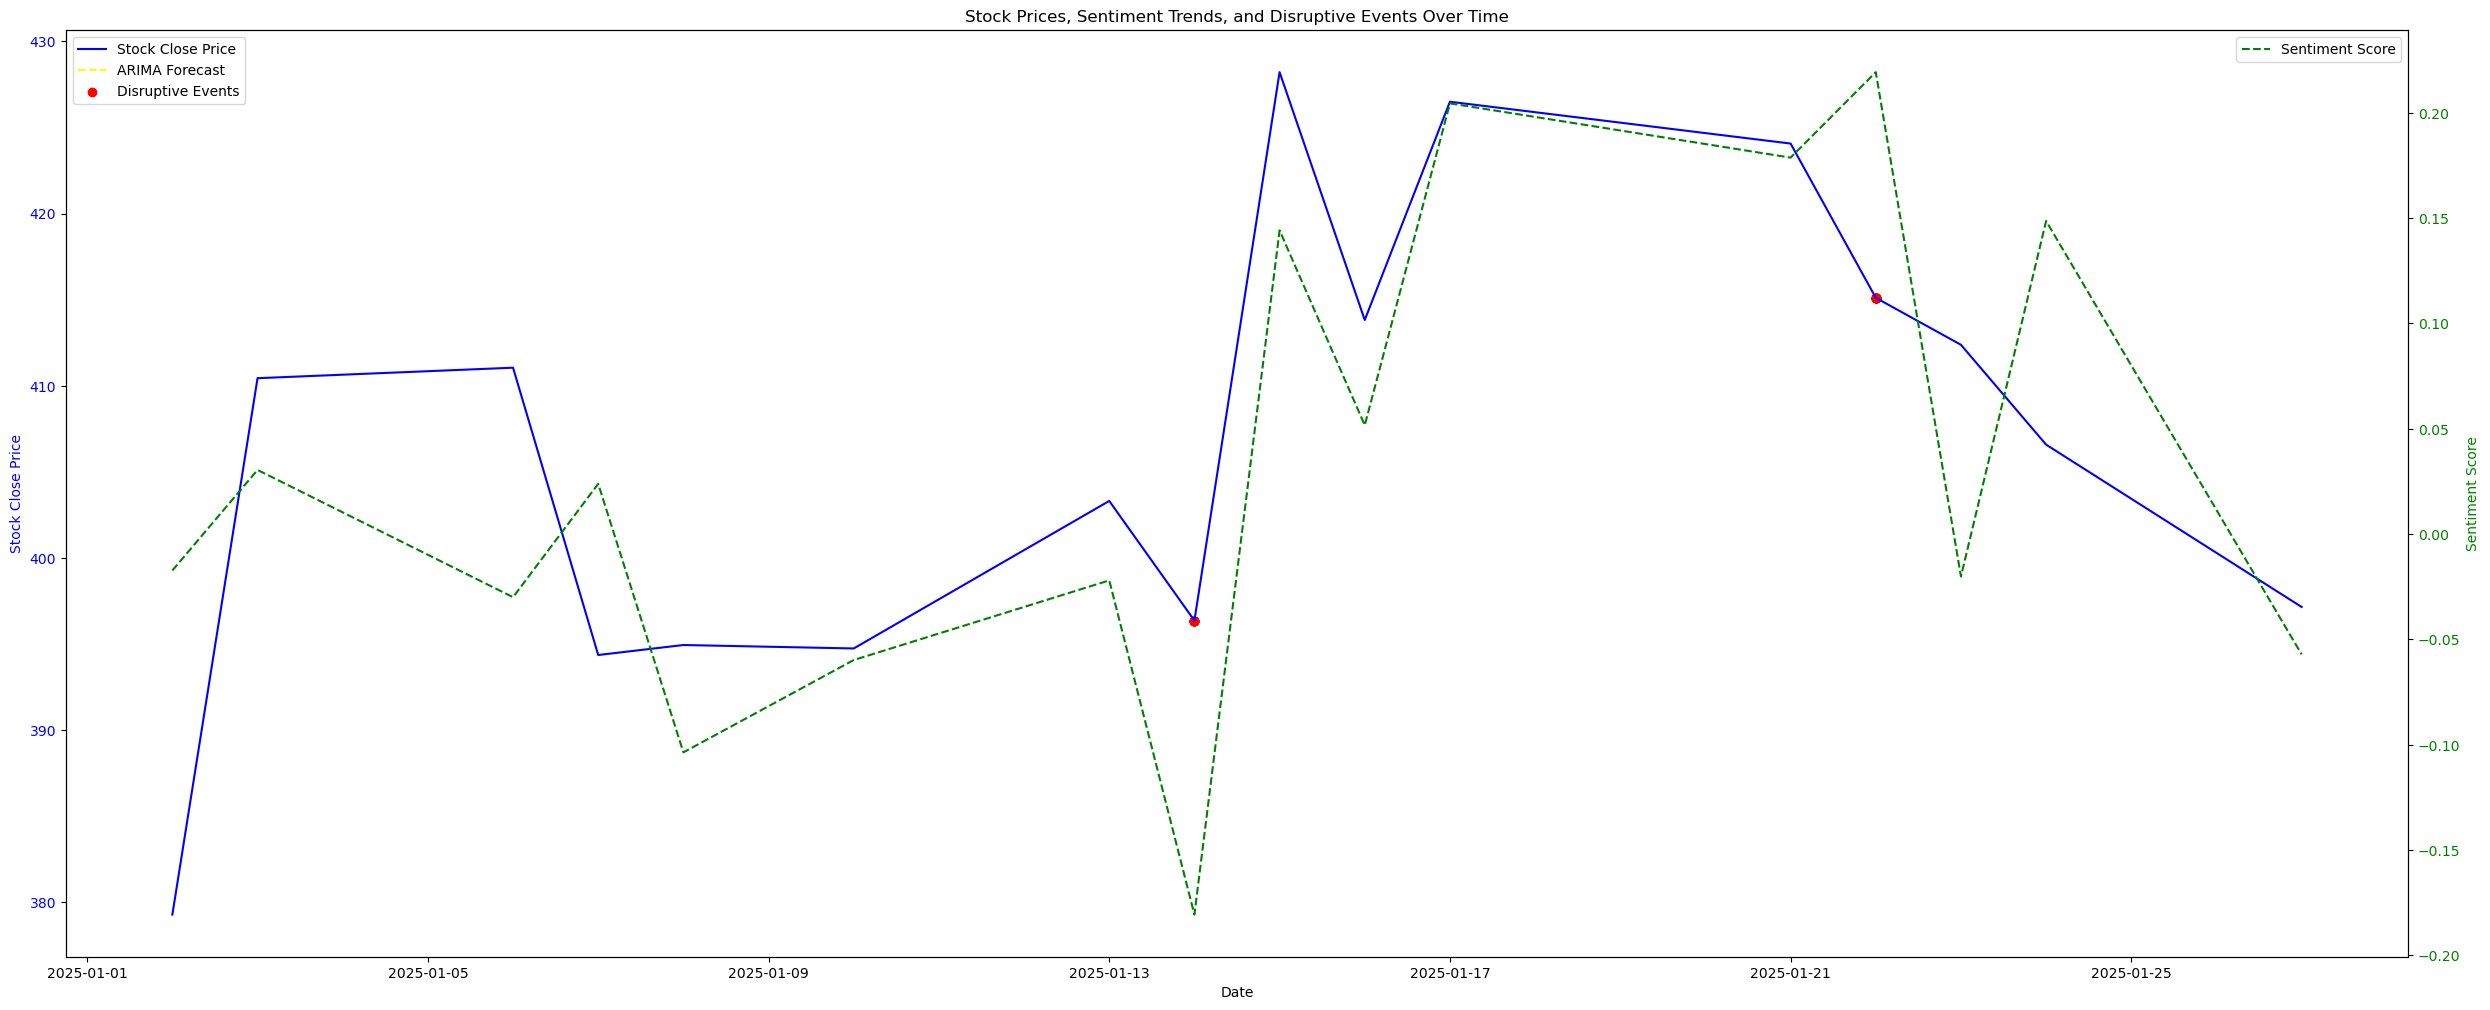

In [68]:
df_merged# --- Continue with plotting ---
fig, ax1 = plt.subplots(figsize=(25, 10))

# Plot Stock Price and ARIMA Forecast
ax1.set_xlabel("Date")
ax1.set_ylabel("Stock Close Price", color="blue")
ax1.plot(df_merged["Date"], df_merged["Close"], color="blue", label="Stock Close Price")
ax1.plot(df_merged["Date"], df_merged["Forecasted_Close"], color="yellow", linestyle="--", label="ARIMA Forecast")
ax1.tick_params(axis="y", labelcolor="blue")

# Create second y-axis for Sentiment Score
ax2 = ax1.twinx()
ax2.set_ylabel("Sentiment Score", color="green")
ax2.plot(df_merged["Date"], df_merged["Sentiment"], color="green", linestyle="dashed", label="Sentiment Score")
ax2.tick_params(axis="y", labelcolor="green")

# Highlight disruptive events with red dots
disruptive = df_merged[df_merged['Anomaly_Label'] == 'Disruptive']
ax1.scatter(disruptive['Date'], disruptive['Close'], color='red', label='Disruptive Events')

# Finalize plot
fig.tight_layout()
plt.title("Stock Prices, Sentiment Trends, and Disruptive Events Over Time")

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.xticks(rotation=45)
plt.show()
